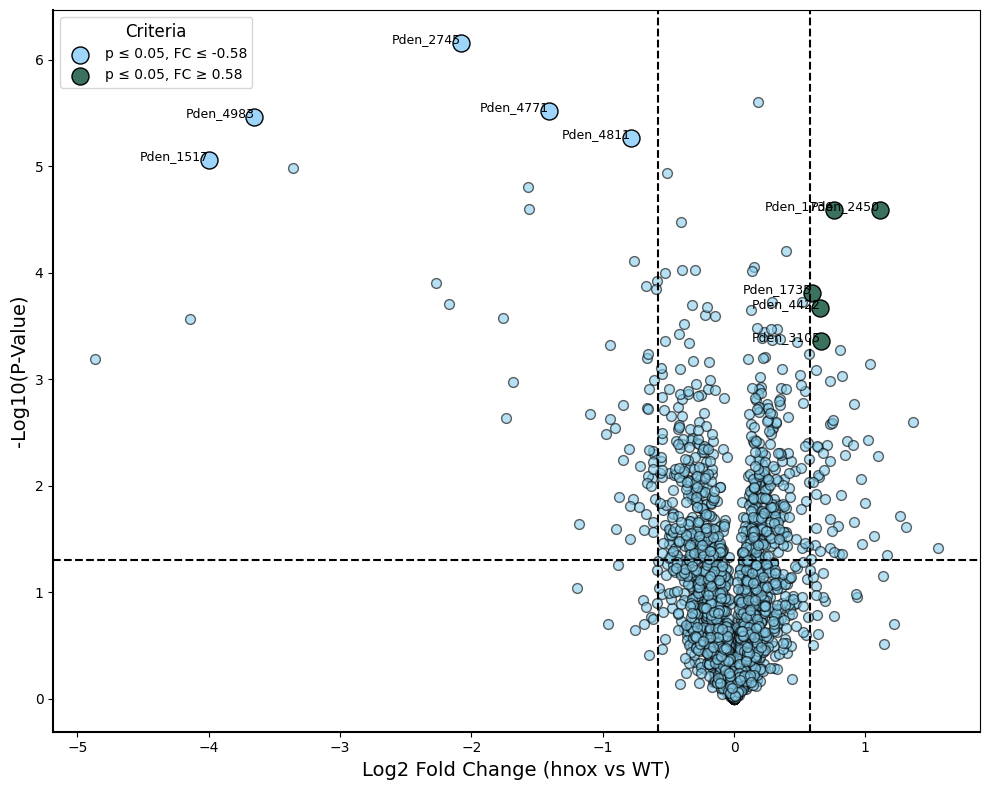

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://github.com/davorbel/Python/raw/main/Protein_group.csv'
df = pd.read_csv(url)
df.head()

# Calculate mean for WT and DM replicates
df['WT_Mean'] = df[['WT_1', 'WT_2', 'WT_3']].mean(axis=1)
df['hnox_Mean'] = df[['hnox_1', 'hnox_2', 'hnox_3']].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['hnox_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['hnox_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_1', 'WT_2', 'WT_3']].values,
    df[['hnox_1', 'hnox_2', 'hnox_3']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# Define significance thresholds
p_threshold = 0.05
fc_threshold = 0.58 # Absolute fold change threshold

# Filter for significant genes based on p-value and fold change
significant_up_regulated = df[(df['P_Value'] < p_threshold) & (df['Log2_FC'] >= fc_threshold)]
significant_down_regulated = df[(df['P_Value'] < p_threshold) & (df['Log2_FC'] <= -fc_threshold)]

# Get the top 5 from each category based on p-value (smallest p-value first)
top_5_up = significant_up_regulated.nsmallest(5, 'P_Value')
top_5_down = significant_down_regulated.nsmallest(5, 'P_Value')

# Concatenate to form the final set of genes to label
top_genes = pd.concat([top_5_down, top_5_up])

# Now use these correct sets for coloring as well
left_candidates = top_5_down
right_candidates = top_5_up


# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB')

# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='#9ED5FA', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≤ -0.58')
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='#3A725D', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≥ 0.58')

# Add gene labels
for _, row in top_genes.iterrows():
    plt.text(row['Log2_FC'], row['MinusLog10_P'], row['gene_symbol'], fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.58, color='black', linestyle='--')
plt.axvline(-0.58, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (hnox vs WT)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()